### Import Modules

In [1]:
# sys
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10000000
import numpy as np
np.set_printoptions(edgeitems=25, linewidth=100000)
import os, sys
from pprint import pprint
%pprint
import time
import warnings
warnings.filterwarnings("ignore")

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
# Graphics in retina: more sharp and legible
%config InlineBackend.figure_format = 'retina'
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'jpg')
import scikitplot as skplt

# Machine Learning
import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_validate, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, accuracy_score, f1_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Pretty printing has been turned OFF


In [3]:
print("Scikit-learn Version: ", sklearn.__version__)
print("Matplotlib Version: ", matplotlib.__version__)
print("Scikit Plot Version : ", skplt.__version__)
print("Pandas Version : ", pd.__version__)
print("Numpy Version : ", np.__version__)
print("Python Version : ", sys.version)

Scikit-learn Version:  1.1.1
Matplotlib Version:  3.5.2
Scikit Plot Version :  0.3.7
Pandas Version :  1.4.2
Numpy Version :  1.22.4
Python Version :  3.10.0 (default, Mar  3 2022, 03:54:28) [Clang 12.0.0 ]


### Load Data

In [2]:
# Load cleaned full dataset
cd = pd.read_csv('data/cleaned_full_dataset.csv')
full_data = cd.copy(deep=True)
full_data.set_index(['cmpd_id', 'smiles'], inplace=True)

# Load cleaned data subset w/ stdev drops
cd = pd.read_csv('data/cleaned_data.csv')
clean_data = cd.copy(deep=True)
clean_data.set_index(['cmpd_id', 'smiles'], inplace=True)

### View Class Balance

In [3]:
# Cleaned full dataset
print('Majority class - Binding: ', sum(full_data['label'] == 1) ) # majority class
print('Minority class - Non-Binding: ', sum(full_data['label'] == 0) ) # minority class

# Cleaned data subset w/ stdev drops
print('\nMajority class - Binding: ', sum(clean_data['label'] == 1) ) # majority class
print('Minority class - Non-Binding: ', sum(clean_data['label'] == 0) ) # minority class

Majority class - Binding:  1177
Minority class - Non-Binding:  1018

Majority class - Binding:  607
Minority class - Non-Binding:  193


### Split Data Into train:test:validation

In [4]:
# Cross-validation
X = full_data.drop(['label','subset'], axis=1)
y = full_data['label']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, shuffle=True ) # Every day we shufflin

X_s = clean_data.drop(['label','subset'], axis=1)
y_s = clean_data['label']

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, 
                                                    random_state=42, shuffle=True ) # Every day we shufflin

### Calculate Class Weights

In [5]:
def generate_class_weights(class_series):
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    
    return dict(zip(class_labels, class_weights))

class_weights = generate_class_weights(y_train)
print('Full data class weights:', class_weights)

# resulting cleaned dataset is imbalanced, so use class weights
class_weights = generate_class_weights(y_train_s)
print('Sub data class weights:', class_weights)

Full data class weights: {0: 1.0826140567200986, 1: 0.9291005291005291}
Sub data class weights: {0: 2.051282051282051, 1: 0.6611570247933884}


In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(x_train_s.shape)
print(x_test_s.shape)
print(y_train_s.shape)
print(y_test_s.shape)

(1756, 208)
(439, 208)
(1756,)
(439,)
(640, 208)
(160, 208)
(640,)
(160,)


### Scale Data

In [8]:
# Feature scaling
scaler = StandardScaler(copy=True)

# fit scaler on training data
scaler.fit(x_train[4:213])

# transform training data
x_train = scaler.transform(x_train)

# fit & transform testing data
scaler.fit(x_test[4:213])
x_test = scaler.transform(x_test)

#-----------------

# fit scaler on training data
scaler.fit(x_train_s[4:213])

# transform training data
x_train_s = scaler.transform(x_train_s)

# fit & transform testing data
scaler.fit(x_test_s[4:213])
x_test_s = scaler.transform(x_test_s)

## Test Various Classifiers

### Linear SVC

#### Full Dataset

CPU times: user 232 ms, sys: 30 ms, total: 262 ms
Wall time: 4.19 s
LinearSVC(C=10, dual=False, max_iter=7000)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.71      0.65      0.68       207\n'
 '           1       0.71      0.77      0.74       232\n'
 '\n'
 '    accuracy                           0.71       439\n'
 '   macro avg       0.71      0.71      0.71       439\n'
 'weighted avg       0.71      0.71      0.71       439\n')


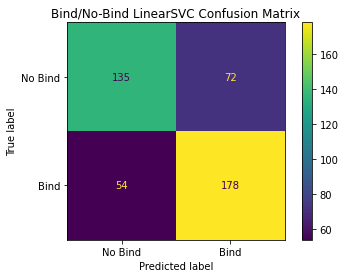

Accuracy: 0.71
Recall: 0.8
Precision: 0.71
F1: 0.74
CPU times: user 535 ms, sys: 615 ms, total: 1.15 s
Wall time: 4.38 s


In [54]:
%%time
# find best model params
params = {'penalty':['l2'],
              'dual':[False],
              'max_iter':[7000],
              "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
              'tol':[1e-4, 1e-3, 1e-2]
             }
              
linearSVC = LinearSVC()

# Gridsearch to determine best params
clf = GridSearchCV(linearSVC, params, n_jobs=-1)

# fit model
%time clf.fit(x_train, y_train)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestlinearSVC = clf.best_estimator_.fit(x_train, y_train)

y_true, y_pred = y_test, bestlinearSVC.predict(x_test)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind LinearSVC Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

#### Sub Dataset

CPU times: user 130 ms, sys: 18.5 ms, total: 148 ms
Wall time: 450 ms
LinearSVC(C=100, dual=False, tol=0.001)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.41      0.97      0.58        37\n'
 '           1       0.99      0.58      0.73       123\n'
 '\n'
 '    accuracy                           0.67       160\n'
 '   macro avg       0.70      0.78      0.65       160\n'
 'weighted avg       0.85      0.67      0.69       160\n')


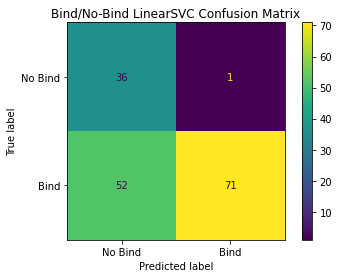

Accuracy: 0.67
Recall: 0.6
Precision: 0.99
F1: 0.73
CPU times: user 631 ms, sys: 777 ms, total: 1.41 s
Wall time: 632 ms


In [55]:
%%time
# find best model params
params = {'penalty':['l2'],
              'dual':[False],
              "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
              'tol':[1e-4, 1e-3, 1e-2]
             }
              
linearSVC = LinearSVC()

# Gridsearch to determine best params
clf = GridSearchCV(linearSVC, params, n_jobs=-1)

# fit model
%time clf.fit(x_train_s, y_train_s)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestlinearSVC = clf.best_estimator_.fit(x_train_s, y_train_s)

y_true, y_pred = y_test_s, bestlinearSVC.predict(x_test_s)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind LinearSVC Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

### KNeighbors Classifier

#### Full Dataset

KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=1, p=1)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.94      0.82      0.88       207\n'
 '           1       0.86      0.96      0.90       232\n'
 '\n'
 '    accuracy                           0.89       439\n'
 '   macro avg       0.90      0.89      0.89       439\n'
 'weighted avg       0.90      0.89      0.89       439\n')


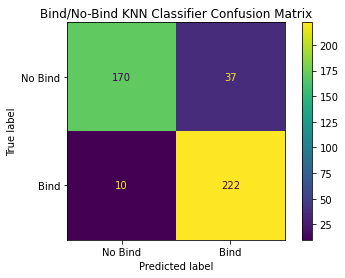

Accuracy: 0.89
Recall: 1.0
Precision: 0.86
F1: 0.90
CPU times: user 7.23 s, sys: 1.75 s, total: 8.98 s
Wall time: 1min 43s


In [9]:
%%time 
# Try KNeighbors Classifier, find best model params
params = {'n_neighbors':[1, 5, 10, 100], 'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'p':[1, 2],
              "leaf_size": [1, 10, 30, 50, 100, 500, 1000],
              'n_jobs':[-1, None]
             }
              
KNC = KNeighborsClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(KNC, params, n_jobs=-1)

# fit model
clf.fit(x_train, y_train)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestKNC = clf.best_estimator_.fit(x_train, y_train)

y_true, y_pred = y_test, bestKNC.predict(x_test)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind KNN Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

#### Sub Dataset

KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=1, p=1)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.94      0.78      0.85        37\n'
 '           1       0.94      0.98      0.96       123\n'
 '\n'
 '    accuracy                           0.94       160\n'
 '   macro avg       0.94      0.88      0.91       160\n'
 'weighted avg       0.94      0.94      0.94       160\n')


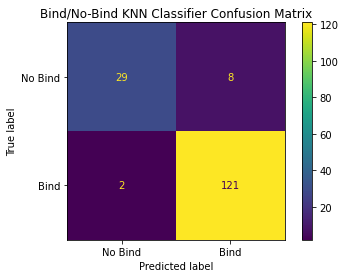

Accuracy: 0.94
Recall: 1.0
Precision: 0.94
F1: 0.96
CPU times: user 1.82 s, sys: 276 ms, total: 2.09 s
Wall time: 17.9 s


In [10]:
%%time 
# Try KNeighbors Classifier, find best model params
params = {'n_neighbors':[1, 5, 10, 100], 'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'p':[1, 2],
              "leaf_size": [1, 10, 30, 50, 100, 500, 1000],
              'n_jobs':[-1, None]
             }
              
KNC = KNeighborsClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(KNC, params, n_jobs=-1)

# fit model
clf.fit(x_train_s, y_train_s)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestKNC = clf.best_estimator_.fit(x_train_s, y_train_s)

y_true, y_pred = y_test_s, bestKNC.predict(x_test_s)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind KNN Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

#### SVC

##### Full Dataset

CPU times: user 3min 40s, sys: 1.12 s, total: 3min 41s
Wall time: 3min 41s
SVC(C=10, class_weight='balanced', decision_function_shape='ovo', tol=0.0001)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.74      0.99      0.84       207\n'
 '           1       0.98      0.69      0.81       232\n'
 '\n'
 '    accuracy                           0.83       439\n'
 '   macro avg       0.86      0.84      0.83       439\n'
 'weighted avg       0.87      0.83      0.83       439\n')


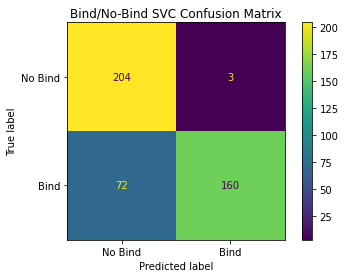

Accuracy: 0.83
Recall: 0.7
Precision: 0.98
F1: 0.81


In [58]:
# find best model params for SVC()
parameters = {'kernel':['linear', 'rbf'], 
              'C':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], 
              'gamma':['scale', 'auto'],
              'tol':[1e-4, 1e-3, 1e-2],
              'class_weight':['balanced'],
              'decision_function_shape':['ovo', 'ovr']
             }
svc = SVC()

# Gridsearch to determine best params
clf = GridSearchCV(svc, parameters)

# fit model
%time clf.fit(x_train, y_train)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestSVC = clf.best_estimator_.fit(x_train, y_train)

y_true, y_pred = y_test, bestSVC.predict(x_test)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind SVC Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

##### Sub Dataset

CPU times: user 24.3 s, sys: 136 ms, total: 24.4 s
Wall time: 24.5 s
SVC(C=10, class_weight='balanced', decision_function_shape='ovo', tol=0.0001)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.77      0.92      0.84        37\n'
 '           1       0.97      0.92      0.95       123\n'
 '\n'
 '    accuracy                           0.92       160\n'
 '   macro avg       0.87      0.92      0.89       160\n'
 'weighted avg       0.93      0.92      0.92       160\n')


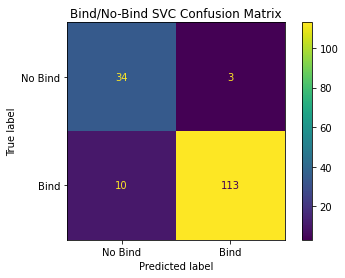

Accuracy: 0.92
Recall: 0.9
Precision: 0.97
F1: 0.95
CPU times: user 24.5 s, sys: 161 ms, total: 24.6 s
Wall time: 24.6 s


In [60]:
%%time
# find best model params for SVC()
parameters = {'kernel':['linear', 'rbf'], 
              'C':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], 
              'gamma':['scale', 'auto'],
              'tol':[1e-4, 1e-3, 1e-2],
              'class_weight':['balanced'],
              'decision_function_shape':['ovo', 'ovr']
             }
svc = SVC()

# Gridsearch to determine best params
clf = GridSearchCV(svc, parameters)

# fit model
%time clf.fit(x_train_s, y_train_s)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestSVC = clf.best_estimator_.fit(x_train_s, y_train_s)

y_true, y_pred = y_test_s, bestSVC.predict(x_test_s)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind SVC Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

#### Bagging Classifier

##### Full Dataset

CPU times: user 21.2 s, sys: 2.89 s, total: 24.1 s
Wall time: 1min 22s
BaggingClassifier(max_samples=10, n_estimators=50, n_jobs=-1, random_state=5)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.73      0.67      0.70       207\n'
 '           1       0.73      0.78      0.75       232\n'
 '\n'
 '    accuracy                           0.73       439\n'
 '   macro avg       0.73      0.73      0.73       439\n'
 'weighted avg       0.73      0.73      0.73       439\n')


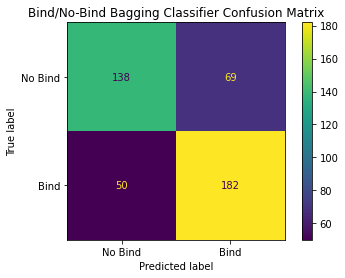

Accuracy: 0.73
Recall: 0.8
Precision: 0.73
F1: 0.75


In [61]:
# find best model params for BaggingClassifier()
parameters = {'n_estimators':[10, 30, 50, 70],
              'max_samples':[1, 3, 5, 7, 10], 
              'random_state':[0, 1, 5, 10], 
              'n_jobs':[-1, None]
             }
bc = BaggingClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(bc, parameters)

# fit model
%time clf.fit(x_train, y_train)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestBC = clf.best_estimator_.fit(x_train, y_train)

y_true, y_pred = y_test, bestBC.predict(x_test)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind Bagging Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

##### Sub Dataset

CPU times: user 14.5 s, sys: 1.73 s, total: 16.2 s
Wall time: 19.7 s
BaggingClassifier(max_samples=10, n_jobs=-1, random_state=5)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.42      0.22      0.29        37\n'
 '           1       0.79      0.91      0.85       123\n'
 '\n'
 '    accuracy                           0.75       160\n'
 '   macro avg       0.61      0.56      0.57       160\n'
 'weighted avg       0.71      0.75      0.72       160\n')


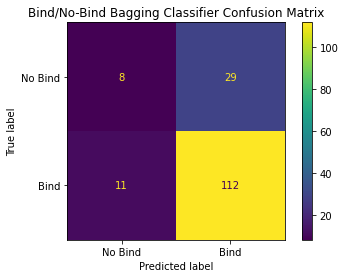

Accuracy: 0.75
Recall: 0.9
Precision: 0.79
F1: 0.85


In [62]:
# find best model params for BaggingClassifier()
parameters = {'n_estimators':[10, 30, 50, 70],
              'max_samples':[1, 3, 5, 7, 10], 
              'random_state':[0, 1, 5, 10], 
              'n_jobs':[-1, None]
             }
bc = BaggingClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(bc, parameters)

# fit model
%time clf.fit(x_train_s, y_train_s)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestBC = clf.best_estimator_.fit(x_train_s, y_train_s)

y_true, y_pred = y_test_s, bestBC.predict(x_test_s)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind Bagging Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

#### Gaussian Process Classifier

##### Full Dataset

CPU times: user 50min 7s, sys: 11min 58s, total: 1h 2min 5s
Wall time: 8min 30s
GaussianProcessClassifier(n_jobs=-1, random_state=0)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.94      0.79      0.86       207\n'
 '           1       0.84      0.96      0.89       232\n'
 '\n'
 '    accuracy                           0.88       439\n'
 '   macro avg       0.89      0.87      0.88       439\n'
 'weighted avg       0.89      0.88      0.88       439\n')


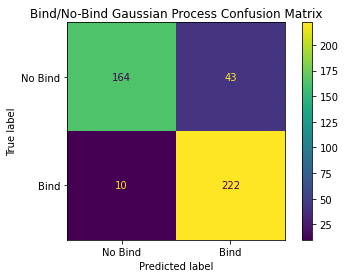

Accuracy: 0.88
Recall: 1.0
Precision: 0.84
F1: 0.89


In [11]:
# find best model params for GaussianProcessClassifier()
parameters = {'max_iter_predict':[100, 500, 1000, 5000], 
              'random_state':[0, 1, 5, 10], 
              'n_jobs':[-1, None]
             }
gpc = GaussianProcessClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(gpc, parameters)

# fit model
%time clf.fit(x_train, y_train)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestGPC = clf.best_estimator_.fit(x_train, y_train)

y_true, y_pred = y_test, bestGPC.predict(x_test)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind Gaussian Process Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

##### Sub Dataset

CPU times: user 18min 59s, sys: 4min 6s, total: 23min 6s
Wall time: 3min 1s
GaussianProcessClassifier(n_jobs=-1, random_state=0)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.89      0.65      0.75        37\n'
 '           1       0.90      0.98      0.94       123\n'
 '\n'
 '    accuracy                           0.90       160\n'
 '   macro avg       0.90      0.81      0.84       160\n'
 'weighted avg       0.90      0.90      0.89       160\n')


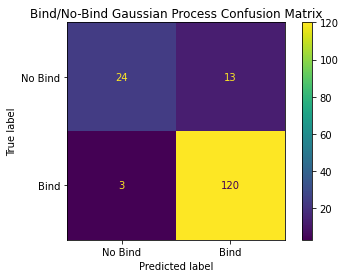

Accuracy: 0.90
Recall: 1.0
Precision: 0.90
F1: 0.94


In [12]:
# find best model params for GaussianProcessClassifier()
parameters = {'max_iter_predict':[100, 500, 1000, 5000], 
              'random_state':[0, 1, 5, 10], 
              'n_jobs':[-1, None]
             }
gpc = GaussianProcessClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(gpc, parameters)

# fit model
%time clf.fit(x_train_s, y_train_s)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestGPC = clf.best_estimator_.fit(x_train_s, y_train_s)

y_true, y_pred = y_test_s, bestGPC.predict(x_test_s)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind Gaussian Process Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

#### Decision Tree Classifier

##### Full Dataset

CPU times: user 11min 55s, sys: 11.9 s, total: 12min 7s
Wall time: 12min 8s
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=50, min_samples_leaf=2, random_state=10,
                       splitter='random')
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.69      0.78      0.73       207\n'
 '           1       0.78      0.68      0.73       232\n'
 '\n'
 '    accuracy                           0.73       439\n'
 '   macro avg       0.73      0.73      0.73       439\n'
 'weighted avg       0.73      0.73      0.73       439\n')


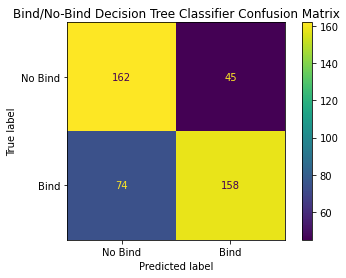

Accuracy: 0.73
Recall: 0.7
Precision: 0.78
F1: 0.73


In [65]:
# find best model params for DecisionTreeClassifier()
parameters = {'criterion':['gini', 'entropy', 'log_loss'], 
              'splitter':['best', 'random'], 
              'max_depth':[5, 10, 50, 100, 1000], 
              'min_samples_leaf':[1, 2, 5, 10], 
              'random_state':[0, 1, 5, 10],
              "max_features": [None, 'sqrt', 'log2'], 
              'class_weight':['balanced'], 
              'ccp_alpha':[0., 0.001, 0.01, 0.1, 1, 2, 5, 10]
             }
dtc = DecisionTreeClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(dtc, parameters)

# fit model
%time clf.fit(x_train, y_train)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestDTC = clf.best_estimator_.fit(x_train, y_train)

y_true, y_pred = y_test, bestDTC.predict(x_test)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind Decision Tree Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

##### Sub Dataset

CPU times: user 3min 5s, sys: 940 ms, total: 3min 6s
Wall time: 3min 6s
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, random_state=1, splitter='random')
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.29      0.92      0.44        37\n'
 '           1       0.93      0.33      0.48       123\n'
 '\n'
 '    accuracy                           0.46       160\n'
 '   macro avg       0.61      0.62      0.46       160\n'
 'weighted avg       0.78      0.46      0.47       160\n')


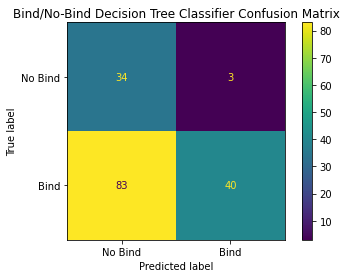

Accuracy: 0.46
Recall: 0.3
Precision: 0.93
F1: 0.48


In [66]:
# find best model params for DecisionTreeClassifier()
parameters = {'criterion':['gini', 'entropy', 'log_loss'], 
              'splitter':['best', 'random'], 
              'max_depth':[5, 10, 50, 100, 1000], 
              'min_samples_leaf':[1, 2, 5, 10], 
              'random_state':[0, 1, 5, 10],
              "max_features": [None, 'sqrt', 'log2'], 
              'class_weight':['balanced'], 
              'ccp_alpha':[0., 0.001, 0.01, 0.1, 1, 2, 5, 10]
             }
dtc = DecisionTreeClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(dtc, parameters)

# fit model
%time clf.fit(x_train_s, y_train_s)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestDTC = clf.best_estimator_.fit(x_train_s, y_train_s)

y_true, y_pred = y_test_s, bestDTC.predict(x_test_s)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind Decision Tree Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

#### Random Forest Classifier

##### Full Dataset

CPU times: user 1h 34min 2s, sys: 48.3 s, total: 1h 34min 51s
Wall time: 2h 1min 4s
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_features=None, n_estimators=70, n_jobs=-1,
                       random_state=1)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.82      0.94      0.88       207\n'
 '           1       0.94      0.82      0.88       232\n'
 '\n'
 '    accuracy                           0.88       439\n'
 '   macro avg       0.88      0.88      0.88       439\n'
 'weighted avg       0.89      0.88      0.88       439\n')


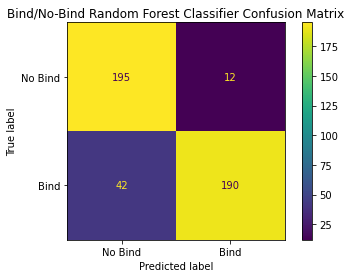

Accuracy: 0.88
Recall: 0.8
Precision: 0.94
F1: 0.88


In [67]:
# find best model params for RandomForestClassifier()
parameters = {'criterion':['gini', 'entropy', 'log_loss'],
              'n_estimators':[10, 30, 50, 70],
              'max_features':[None],
              'class_weight':['balanced', 'balanced_subsample'],
              'ccp_alpha':[0., 0.001, 0.01, 0.1, 1, 2, 5, 10],
              'random_state':[0, 1, 5, 10],
              'n_jobs':[-1, None]
              
             }
rfc = RandomForestClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(rfc, parameters)

# fit model
%time clf.fit(x_train, y_train)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestRFC = clf.best_estimator_.fit(x_train, y_train)

y_true, y_pred = y_test, bestRFC.predict(x_test)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind Random Forest Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

##### Sub Dataset

CPU times: user 21min 59s, sys: 32.1 s, total: 22min 31s
Wall time: 25min 43s
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=None, n_estimators=70, n_jobs=-1,
                       random_state=1)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.27      0.95      0.42        37\n'
 '           1       0.94      0.24      0.39       123\n'
 '\n'
 '    accuracy                           0.41       160\n'
 '   macro avg       0.61      0.59      0.41       160\n'
 'weighted avg       0.78      0.41      0.40       160\n')


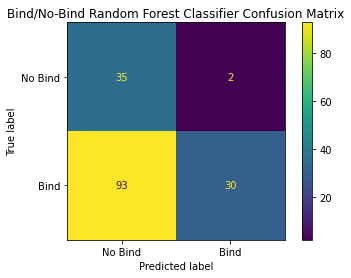

Accuracy: 0.41
Recall: 0.2
Precision: 0.94
F1: 0.39


In [68]:
# find best model params for RandomForestClassifier()
parameters = {'criterion':['gini', 'entropy', 'log_loss'],
              'n_estimators':[10, 30, 50, 70],
              'max_features':[None],
              'class_weight':['balanced', 'balanced_subsample'],
              'ccp_alpha':[0., 0.001, 0.01, 0.1, 1, 2, 5, 10],
              'random_state':[0, 1, 5, 10],
              'n_jobs':[-1, None]
              
             }
rfc = RandomForestClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(rfc, parameters)

# fit model
%time clf.fit(x_train_s, y_train_s)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestRFC = clf.best_estimator_.fit(x_train_s, y_train_s)

y_true, y_pred = y_test_s, bestRFC.predict(x_test_s)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind Random Forest Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

#### MLP Classifier

##### Full Dataset

CPU times: user 41min 54s, sys: 1min 51s, total: 43min 46s
Wall time: 5min 48s
{'activation': 'tanh',
 'early_stopping': True,
 'learning_rate': 'adaptive',
 'random_state': 5,
 'shuffle': True,
 'solver': 'lbfgs'}
MLPClassifier(activation='tanh', early_stopping=True, learning_rate='adaptive',
              random_state=5, solver='lbfgs')
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.85      0.93      0.89       207\n'
 '           1       0.93      0.85      0.89       232\n'
 '\n'
 '    accuracy                           0.89       439\n'
 '   macro avg       0.89      0.89      0.89       439\n'
 'weighted avg       0.89      0.89      0.89       439\n')


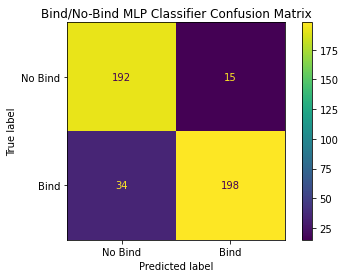

Accuracy: 0.89
Recall: 0.9
Precision: 0.93
F1: 0.89


In [13]:
# find best model params for MLPClassifier()
parameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 
              'solver':['lbfgs', 'sgd', 'adam'], 
              'learning_rate':['adaptive', 'constant', 'invscaling'],
              'shuffle':[True],
              'random_state':[None, 1, 5, 10],
              'early_stopping':[True]
             }
mlpc = MLPClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(mlpc, parameters)

# fit model
%time clf.fit(x_train, y_train)

# show best params
pprint(clf.best_params_)
pprint(clf.best_estimator_)

# use best estimator
bestMLP = clf.best_estimator_.fit(x_train, y_train)

y_true, y_pred = y_test, bestMLP.predict(x_test)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind MLP Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

##### Sub Dataset

CPU times: user 7min 25s, sys: 15.9 s, total: 7min 41s
Wall time: 1min 4s
MLPClassifier(activation='tanh', early_stopping=True, learning_rate='adaptive',
              random_state=5, solver='lbfgs')
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.63      0.92      0.75        37\n'
 '           1       0.97      0.84      0.90       123\n'
 '\n'
 '    accuracy                           0.86       160\n'
 '   macro avg       0.80      0.88      0.82       160\n'
 'weighted avg       0.89      0.86      0.86       160\n')


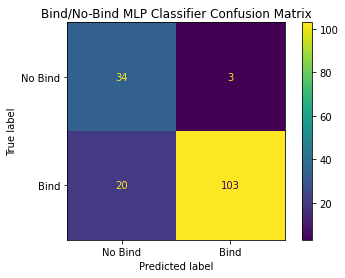

Accuracy: 0.86
Recall: 0.8
Precision: 0.97
F1: 0.90


In [70]:
# find best model params for MLPClassifier()
parameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 
              'solver':['lbfgs', 'sgd', 'adam'], 
              'learning_rate':['adaptive'],
              'shuffle':[True],
              'random_state':[None, 1, 5, 10],
              'early_stopping':[True]
             }
mlpc = MLPClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(mlpc, parameters)

# fit model
%time clf.fit(x_train_s, y_train_s)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestMLP = clf.best_estimator_.fit(x_train_s, y_train_s)

y_true, y_pred = y_test_s, bestMLP.predict(x_test_s)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind MLP Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

#### AdaBoost Classifier

##### Full Dataset

CPU times: user 45min 38s, sys: 8.2 s, total: 45min 47s
Wall time: 45min 48s
AdaBoostClassifier(learning_rate=1, n_estimators=1000)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.55      0.86      0.67       207\n'
 '           1       0.75      0.38      0.51       232\n'
 '\n'
 '    accuracy                           0.61       439\n'
 '   macro avg       0.65      0.62      0.59       439\n'
 'weighted avg       0.66      0.61      0.59       439\n')


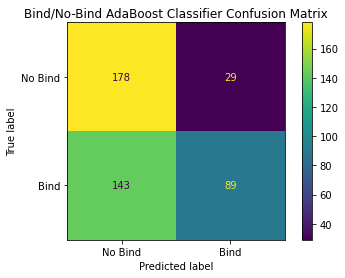

Accuracy: 0.61
Recall: 0.4
Precision: 0.75
F1: 0.51


In [71]:
# find best model params for AdaBoostClassifier()
parameters = {'n_estimators':[30, 50, 100, 500, 1000], 
              'learning_rate':[1e-4, 1e-3, 1e-2, .1, 1], 
              'algorithm':['SAMME', 'SAMME.R'],
              'random_state':[None, 1, 5, 10]
             }
abc = AdaBoostClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(abc, parameters)

# fit model
%time clf.fit(x_train, y_train)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestABC = clf.best_estimator_.fit(x_train, y_train)

y_true, y_pred = y_test, bestABC.predict(x_test)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind AdaBoost Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

##### Sub Dataset

CPU times: user 15min 59s, sys: 3.17 s, total: 16min 2s
Wall time: 16min 3s
AdaBoostClassifier(learning_rate=1, n_estimators=100)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.33      0.97      0.50        37\n'
 '           1       0.98      0.41      0.58       123\n'
 '\n'
 '    accuracy                           0.54       160\n'
 '   macro avg       0.66      0.69      0.54       160\n'
 'weighted avg       0.83      0.54      0.56       160\n')


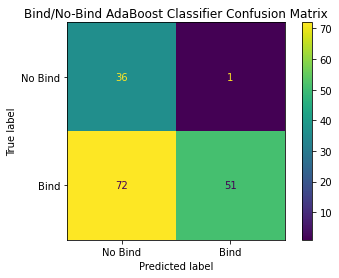

Accuracy: 0.54
Recall: 0.4
Precision: 0.98
F1: 0.58


In [72]:
# find best model params for AdaBoostClassifier()
parameters = {'n_estimators':[30, 50, 100, 500, 1000], 
              'learning_rate':[1e-4, 1e-3, 1e-2, .1, 1], 
              'algorithm':['SAMME', 'SAMME.R'],
              'random_state':[None, 1, 5, 10]
             }
abc = AdaBoostClassifier()

# Gridsearch to determine best params
clf = GridSearchCV(abc, parameters)

# fit model
%time clf.fit(x_train_s, y_train_s)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestABC = clf.best_estimator_.fit(x_train_s, y_train_s)

y_true, y_pred = y_test_s, bestABC.predict(x_test_s)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind AdaBoost Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

#### Gaussian Naive Bayes

##### Full Dataset

CPU times: user 90.1 ms, sys: 20.2 ms, total: 110 ms
Wall time: 112 ms
GaussianNB(var_smoothing=0.01)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.73      0.66      0.69       207\n'
 '           1       0.72      0.78      0.75       232\n'
 '\n'
 '    accuracy                           0.72       439\n'
 '   macro avg       0.72      0.72      0.72       439\n'
 'weighted avg       0.72      0.72      0.72       439\n')


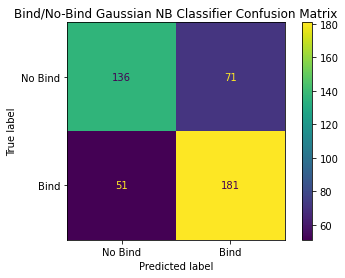

Accuracy: 0.72
Recall: 0.8
Precision: 0.72
F1: 0.75


In [73]:
# find best model params for GaussianNB()
parameters = {'var_smoothing':[1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2,  0.1], 
             }
gnb = GaussianNB()

# Gridsearch to determine best params
clf = GridSearchCV(gnb, parameters)

# fit model
%time clf.fit(x_train, y_train)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestGNB = clf.best_estimator_.fit(x_train, y_train)

y_true, y_pred = y_test, bestGNB.predict(x_test)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind Gaussian NB Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

##### Sub Dataset

CPU times: user 131 ms, sys: 6.24 ms, total: 138 ms
Wall time: 52.9 ms
GaussianNB(var_smoothing=0.01)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.47      0.95      0.62        37\n'
 '           1       0.98      0.67      0.80       123\n'
 '\n'
 '    accuracy                           0.74       160\n'
 '   macro avg       0.72      0.81      0.71       160\n'
 'weighted avg       0.86      0.74      0.76       160\n')


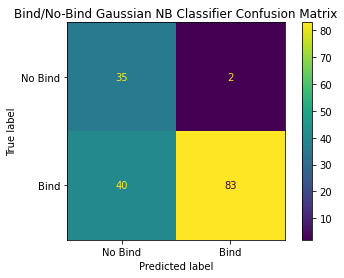

Accuracy: 0.74
Recall: 0.7
Precision: 0.98
F1: 0.80


In [74]:
# find best model params for GaussianNB()
parameters = {'var_smoothing':[1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2,  0.1], 
             }
gnb = GaussianNB()

# Gridsearch to determine best params
clf = GridSearchCV(gnb, parameters)

# fit model
%time clf.fit(x_train_s, y_train_s)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestGNB = clf.best_estimator_.fit(x_train_s, y_train_s)

y_true, y_pred = y_test_s, bestGNB.predict(x_test_s)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind Gaussian NB Classifier Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

#### Quadratic Discriminant Analysis

##### Full Dataset

CPU times: user 12.2 s, sys: 651 ms, total: 12.9 s
Wall time: 1.93 s
QuadraticDiscriminantAnalysis(tol=1e-05)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.47      1.00      0.64       207\n'
 '           1       1.00      0.00      0.01       232\n'
 '\n'
 '    accuracy                           0.47       439\n'
 '   macro avg       0.74      0.50      0.33       439\n'
 'weighted avg       0.75      0.47      0.31       439\n')


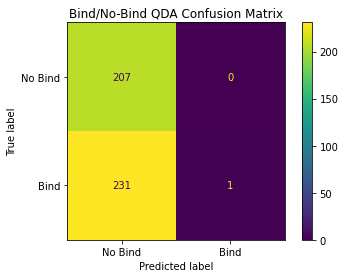

Accuracy: 0.47
Recall: 0.0
Precision: 1.00
F1: 0.01


In [75]:
# find best model params for QuadraticDiscriminantAnalysis()
parameters = {'tol':[1e-5, 1e-4, 1e-3, 1e-2]}

qda = QuadraticDiscriminantAnalysis()

# Gridsearch to determine best params
clf = GridSearchCV(qda, parameters)

# fit model
%time clf.fit(x_train, y_train)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestQDA = clf.best_estimator_.fit(x_train, y_train)

y_true, y_pred = y_test, bestQDA.predict(x_test)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind QDA Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

##### Sub Dataset

CPU times: user 4.72 s, sys: 159 ms, total: 4.88 s
Wall time: 691 ms
QuadraticDiscriminantAnalysis(tol=1e-05)
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.00      0.00      0.00        37\n'
 '           1       0.77      1.00      0.87       123\n'
 '\n'
 '    accuracy                           0.77       160\n'
 '   macro avg       0.38      0.50      0.43       160\n'
 'weighted avg       0.59      0.77      0.67       160\n')


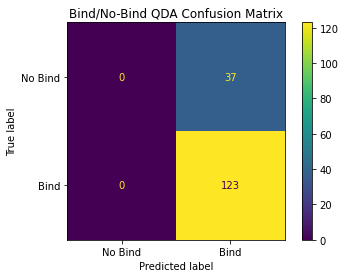

Accuracy: 0.77
Recall: 1.0
Precision: 0.77
F1: 0.87


In [76]:
# find best model params for QuadraticDiscriminantAnalysis()
parameters = {'tol':[1e-5, 1e-4, 1e-3, 1e-2]}

qda = QuadraticDiscriminantAnalysis()

# Gridsearch to determine best params
clf = GridSearchCV(qda, parameters)

# fit model
%time clf.fit(x_train_s, y_train_s)

# show best params
pprint(clf.best_estimator_)

# use best estimator
bestQDA = clf.best_estimator_.fit(x_train_s, y_train_s)

y_true, y_pred = y_test_s, bestQDA.predict(x_test_s)

# make classification report
pprint(classification_report(y_true, y_pred))

# make confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Bind', 'Bind'])
disp.plot()
plt.title('Bind/No-Bind QDA Confusion Matrix')
plt.show()

# view accuracy, precision, recall, f1 scores
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("Recall: %0.1f" % recall_score(y_true, y_pred))
print("Precision: %0.2f" % precision_score(y_true, y_pred))
print("F1: %0.2f" % f1_score(y_true, y_pred))

## Plotting

### Full Dataset

In [144]:
names = [
    "K Neighbors",
    "Gaussian Process",
    "Neural Net"
]

# use top 3 best estimators
classifiers = [
    KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=1, p=1),
    GaussianProcessClassifier(n_jobs=-1, random_state=0),
    MLPClassifier(activation='tanh', early_stopping=True, learning_rate='adaptive',
              solver='lbfgs')
]

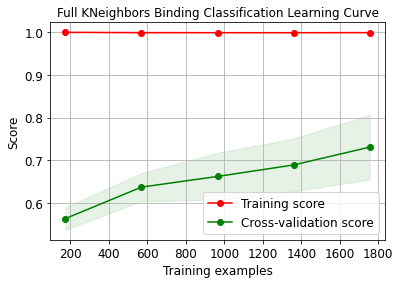

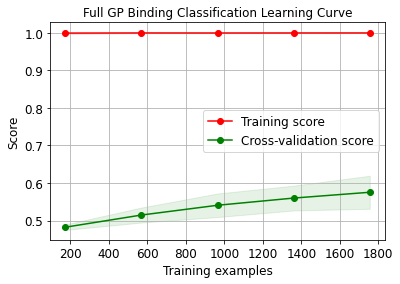

In [148]:
# Cross Validation Performance Plots
skplt.estimators.plot_learning_curve(KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=1, p=1), 
                                     X, y,
                                     shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Full KNeighbors Binding Classification Learning Curve");

skplt.estimators.plot_learning_curve(GaussianProcessClassifier(n_jobs=-1, random_state=0), 
                                     X, y,
                                     shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Full GP Binding Classification Learning Curve");

# skplt.estimators.plot_learning_curve(MLPClassifier(activation='tanh', early_stopping=True, learning_rate='adaptive',
#                                                    solver='lbfgs', max_iter=50000),
#                                      X, y,
#                                      shuffle=True, scoring="accuracy",
#                                      n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
#                                      title="Full MLP Binding Classification Learning Curve");


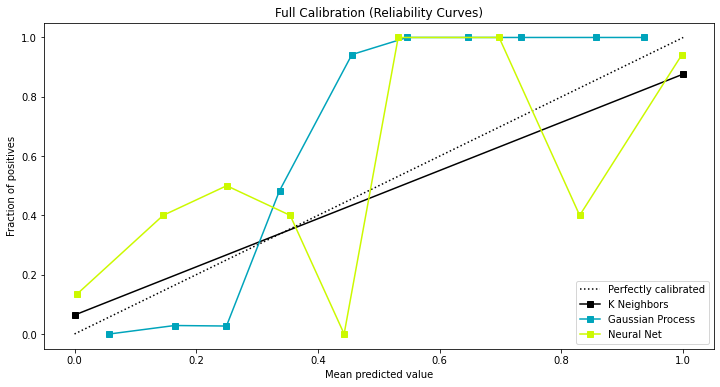

In [149]:
# 'Calibration plots (Reliability Curves)'
knn_proba = KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=1, p=1).fit(x_train, 
                                                y_train).predict_proba(x_test)
gp_proba = GaussianProcessClassifier(n_jobs=-1, random_state=0).fit(x_train, 
                                                y_train).predict_proba(x_test)
mlp_proba = MLPClassifier(activation='tanh', early_stopping=True, 
                          learning_rate='adaptive', random_state=1, solver='lbfgs').fit(x_train, y_train).predict_proba(x_test)

probas_list = [knn_proba, gp_proba, mlp_proba]

skplt.metrics.plot_calibration_curve(y_test,
                                     probas_list,
                                     names,
                                     title='Full Calibration (Reliability Curves)',
                                     figsize=(12,6)
                                     );

### Sub Dataset

In [128]:
names = [
    "K Neighbors",
    "Non-Linear Support Vector",
    "Gaussian Process"
]

# use best estimators
classifiers = [
    KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=1, p=1),
    SVC(C=10, class_weight='balanced', decision_function_shape='ovo', 
        tol=0.0001),
    GaussianProcessClassifier(n_jobs=-1, random_state=0)
]

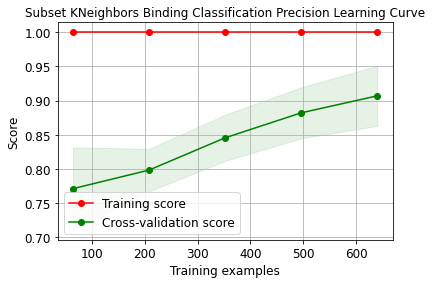

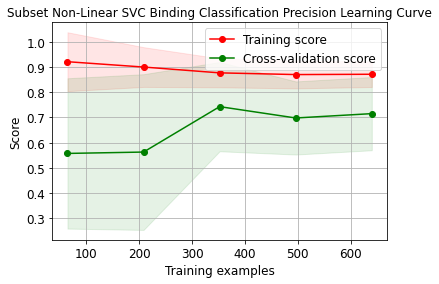

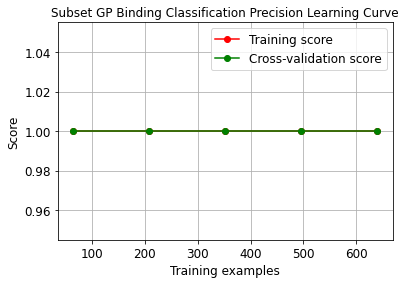

In [ ]:
# Cross Validation Performance Plots
skplt.estimators.plot_learning_curve(KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=1, p=1), 
                                     X_s, y_s,
                                     shuffle=True, scoring="precision",
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Subset KNeighbors Binding Classification Precision Learning Curve");

skplt.estimators.plot_learning_curve(SVC(C=10, class_weight='balanced', decision_function_shape='ovo', 
                                         tol=0.0001), 
                                     X_s, y_s,
                                     shuffle=True, scoring="precision",
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Subset Non-Linear SVC Binding Classification Precision Learning Curve");

skplt.estimators.plot_learning_curve(GaussianProcessClassifier(n_jobs=-1, random_state=0), 
                                     X_s, y_s,
                                     shuffle=True, scoring="precision",
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Subset GP Binding Classification Precision Learning Curve");


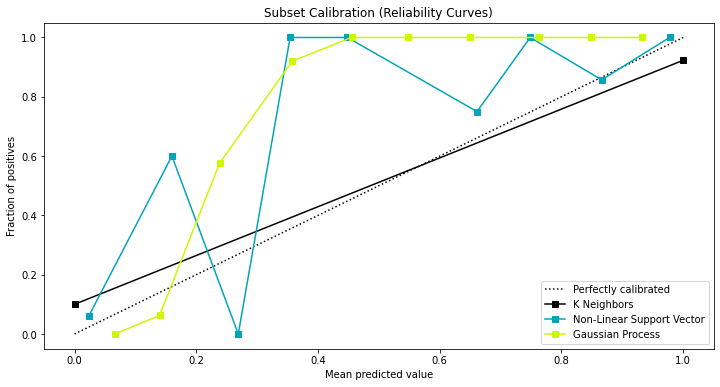

In [131]:
# 'Calibration plots (Reliability Curves)'
knn_proba = KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=1, p=1).fit(x_train_s, 
                                                y_train_s).predict_proba(x_test_s)
svc_proba = SVC(C=10, class_weight='balanced', probability=True, 
    decision_function_shape='ovo', tol=0.0001).fit(x_train_s, 
                                                y_train_s).predict_proba(x_test_s)
gp_proba = GaussianProcessClassifier(n_jobs=-1, random_state=0).fit(x_train_s, 
                                                y_train_s).predict_proba(x_test_s)
probas_list = [knn_proba, svc_proba, gp_proba]

skplt.metrics.plot_calibration_curve(y_test_s,
                                     probas_list,
                                     names,
                                     title='Subset Calibration (Reliability Curves)',
                                     figsize=(12,6)
                                     );